## Introduction

In this project we will attempt to create a model to predict the sentiment of tweets on Twitter regarrding climate change. Sentiment analysis refers to classifying the sentiments that is collocted from a text source. In this project we will be using Twitter data because of the large amount of data availible. This data is thus usefull in trying to understand the opinions of people regarding climate change.

## What is Natural Language Processing?

Natural language is the language you and I talk in. It could be Hindi, English, Spanish, anything. And we talk about natural language processing, we basically refer to making computers able to process this language, and more importantly understand it and take actions based on it. Now this language can be text based or audio based. Your Google Voice assistant, Siri and even google translator are great examples of this.


## Problem Satement

We are going to build a machine learning model that is able to analyze loads of twitter tweets, and be able to judge the sentiments behind the tweets. We are going to be analyzing tweets made about climate change, and judging if they are of positive, negative or neutral sentiments. These types of models are massively used by Twitter and Facebook, to filter out to say hate speeches, or other unwanted comments on their platforms.

Thus in this project we aim to analyze the tweets provided from the dataset by creating a machine learning model in order to predict the sentiment future tweets. 

## Import Packages
Here we import the packages and modules that will be used in this project.

In [61]:
# Import packages

# Database manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

# Natural language Toolkit packages.
# Necessary libraries and modules that are 
# going to help us do the data processing 
# from the nltk library.
import nltk

#nltk.download(['punkt','stopwords'])
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
import string

# Regular expression
import re

# to make bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages to create models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC  # Model takes to long to train
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample

# Save trained models
import pickle


import warnings
warnings.filterwarnings('ignore')

## Read and Load the Dataset

Here we import the dataset so that we will be able to manipulate the data.

In [2]:
# Import dataset

tweets = pd.read_csv("train.csv")

## Exploratory Data Analysis

short explanation

#### Top 5 records of the data

In [183]:
tweets.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


#### Columns/features in the data

In [134]:
tweets.columns

Index(['sentiment', 'message', 'tweetid'], dtype='object')

#### Length of the dataset

In [135]:
print('The length of the data is', len(tweets))

The length of the data is 15819


#### Shape of the data

In [136]:
tweets.shape

(15819, 3)

 The shape of the data, when you print it, will be shown as (15819, 3). Basically means that there are 15819 tweets in the dataset, with 3 parameters associated with each tweet.

#### Data Information

In [184]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


#### Check for Null values

In [190]:
tweets.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

#### Check uniques target values

In [4]:
tweets['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

#### Sentiment Description:
* 2 News: the tweet links to factual news about climate change

* 1 Pro: the tweet supports the belief of man-made climate change

* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

* -1 Anti: the tweet does not believe in man-made climate change

#### Number of target values

In [5]:
tweets['sentiment'].nunique()

4

Above we can see that the dataset has four unique target variables.

## Data Visualization of Target Variables

Here we will be plotting the distributions of the dataset in different ways.

#### Pie chart

<AxesSubplot:ylabel='sentiment'>

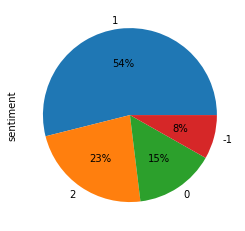

In [6]:
tweets['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

From the output pie chart we can see the sentiments: 1 Pro: climate change holds the majority of tweets

#### Bar chart

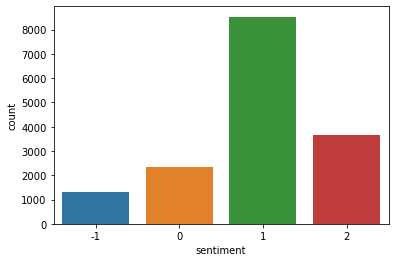

In [7]:
sns.countplot(x='sentiment', data=tweets)
plt.show()

## Data Preprocessing  


In NLP projects, the most important part is preprocessing the data, so that it is ready for a model to use. That’s what we are doing now.
Since there is a unnecessary parameters in the dataset, lets extract and store the input and the output, which is the 'message' and 'sentiment'  column using the following lines:

### Class imbalances
As we can see from the distrubution plot above there are inbalances in the datasaet. Below we will attempt to correct the imbalances in the data by resampling.

In [3]:
pro_df = tweets[tweets['sentiment'] == 1]
anti_df = tweets[tweets['sentiment'] == -1]
neutral_df = tweets[tweets['sentiment'] == 0]
news_df = tweets[tweets['sentiment'] == 2]

print('pro_df:' ,len(pro_df),'\nanti_df:',len(anti_df), '\nneutral_df:', len(neutral_df), '\nnews_df:', len(news_df))

pro_df: 8530 
anti_df: 1296 
neutral_df: 2353 
news_df: 3640


Below we will resample the data, as we can see the highest value is pro_df has 8530 entries, and the lowest value is anti_df with 1296, thus a good middle ground is news_df at 3640.
We will downsample data > 3640 and upsample data < 3640.

In [4]:
# Downsample
pro_df_scale = resample(pro_df,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=len(news_df), # match number in minority class
                          random_state=42) 

# Upsamle
neutral_df_scale = resample(neutral_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=len(news_df), # match number in minority class
                          random_state=42)

anti_df_scale = resample(anti_df,
                          replace=True, # sample without replacement (no need to duplicate observations)
                          n_samples=len(news_df), # match number in minority class
                          random_state=42)

In [5]:
print('pro_df size:' ,len(pro_df_scale),'\nanti_df:',len(anti_df_scale), '\nneutral_df:', len(neutral_df_scale), '\nnews_df:', len(news_df))

pro_df size: 3640 
anti_df: 3640 
neutral_df: 3640 
news_df: 3640


In [6]:
# combine dataframe

data = pd.concat([pro_df_scale,anti_df_scale,neutral_df_scale,news_df])
data.shape

(14560, 3)

Seperate features and targets

In [8]:
len(y)

15819

### What do we need to do in Data Processing?

Remember your input is just a bunch of words for now. Machine learning models only understand and work on numbers. So we have to convert all the text into numbers.

To remove unnecessary words, I am going to use the following techniques:

1. Removing Stop Words and url: Basically words like this, an, a, the, etc that do not affect the meaning of the tweet
2. Removing Punctuation: (‘,.*!’) and other punctuation marks that are not really needed by the model
3. Stemming: Basically reducing words like ‘jumping, jumped, jump’ into its root word(also called stem), which is jump in this case. Since all variations of the root word convey the same meaning, we don’t need each of the word to be converted into different numbers.
4. Lemmatization: Lemmatizing is the process of grouping words of similar meaning together

Step 3 and 4 will be compled together.

First the stopwords and puntuation is declared.

In [12]:
stop_words = stopwords.words('english')
punct = string.punctuation


In [13]:
# We simply store the english stop words,the stemmer function
# in different variables in the following lines.

stemmer1 = PorterStemmer()
lemmatizer = WordNetLemmatizer()

Below is initial data cleaning with no resampled data. This cleaned_data will be used to ensure the cleaing process is sufficient before moving on to additional functions.

In [14]:

X = tweets['message']
y = tweets['sentiment']

In [15]:
cleaned_data_1=[]

for i in range(len(X)):
    tweet=re.sub(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?',' ',X.iloc[i])  #Removing urls from messages
    tweet=re.sub('[^a-zA-Z]',' ',tweet)                                            #Makes sure only letter are in the message 
    tweet=tweet.lower().split()
    tweet=[stemmer1.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    tweet=' '.join(tweet)    # Joining the cleaned split words
    cleaned_data_1.append(tweet)
    


Have a look at the cleaned data below.

In [16]:
cleaned_data_1[:5]

['polyscimajor epa chief think carbon dioxid main caus global warm wait',
 'like lack evid anthropogen global warm',
 'rt rawstori research say three year act climat chang late',
 'todayinmak wire pivot year war climat chang',
 'rt soynoviodetoda racist sexist climat chang deni bigot lead poll electionnight']

Firstly, we create an empty list called cleaned_data, where will be storing our text data after getting rid of all unnecessary words.

We import a library called re(regular expressions), that is gonna help us remove a lot of unnecessary stuff.

To begin with, we run a for loop to iterate through each and every tweet in the dataset, at a time. Using re.sub we can substitute and replace things in a sentence. So we are basically taking one tweet at a time, and inside it whatever is not a letter(belonging to a-z or A-Z) and url, will be replaced by an empty space. It will automatically filter out punctuation marks and other non-letters.

In the next line, we convert all words into lower cases and split them into a list.

Next, we iterate through each word in a tweet, and if that word is not a stop word, and not a punctuation mark,we use the word, later this will be used to satisfy the condition for the stemming and lemmatization functions.

After that we join all the words using ‘’.join(tweet), to get a single sentence instead of separated words. And then we simply append that into the cleaned data list that we had created. If you print the cleaned list it should look something the above .

This will be done for all features sets.



### Wordcloud for feature set 1

A wordcloud of this cleaned data will be created to visualize the most frequent 100 word, to make sure that that the words meaningful to the machine learning goal.

A wordcloud will be created for each cleaned data group.


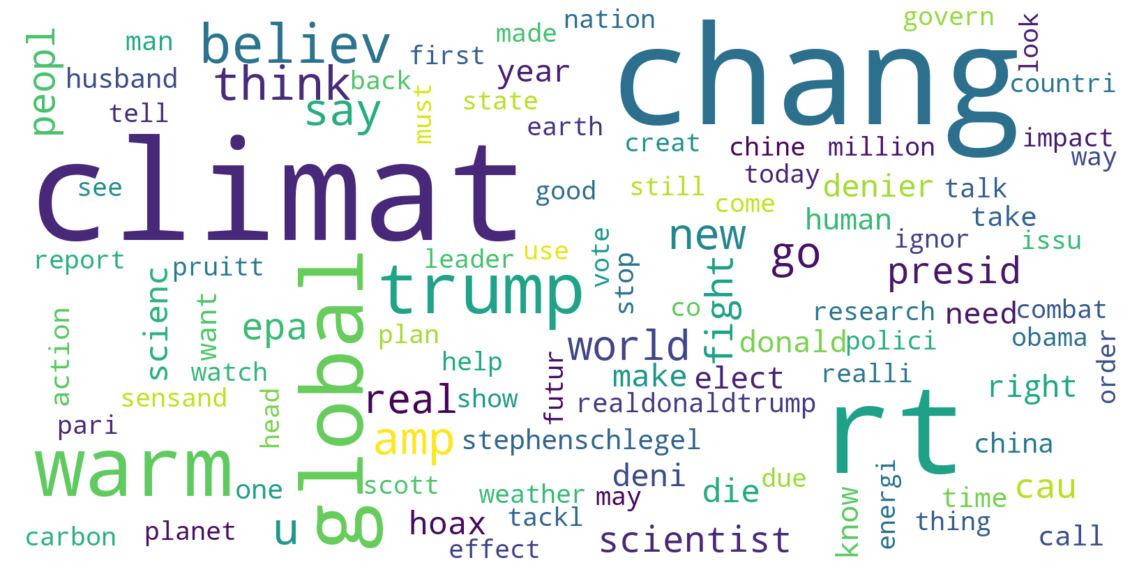

In [32]:
string_1 = pd.Series(cleaned_data_1).str.cat(sep=' ')   #This creates a list of single strings.

wordcloud_1 = WordCloud(width=1600,height=800,max_font_size=200,max_words=100,
                       collocations = False, background_color = 'white').generate(string_1)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.show()

In this, climate and change is the subject for which the tweets are made. We’ll also remove them later, as they do not play a role in the sentiment of the tweet.

We can add our own stopwords as per our need. We know the words like “climate”,”change”,”global”,”warming” will be very common in tweets that had to do with climate change. So we add them to stopwords list and they won’t appear in the word cloud.

Below we will create a list of additional stopwords and show a new wordcloud. This list will be expanded by more words from additional cleaned data.

In [17]:
add_stopwords= ["climat","chang","global","warm","rt","http","https","u"]


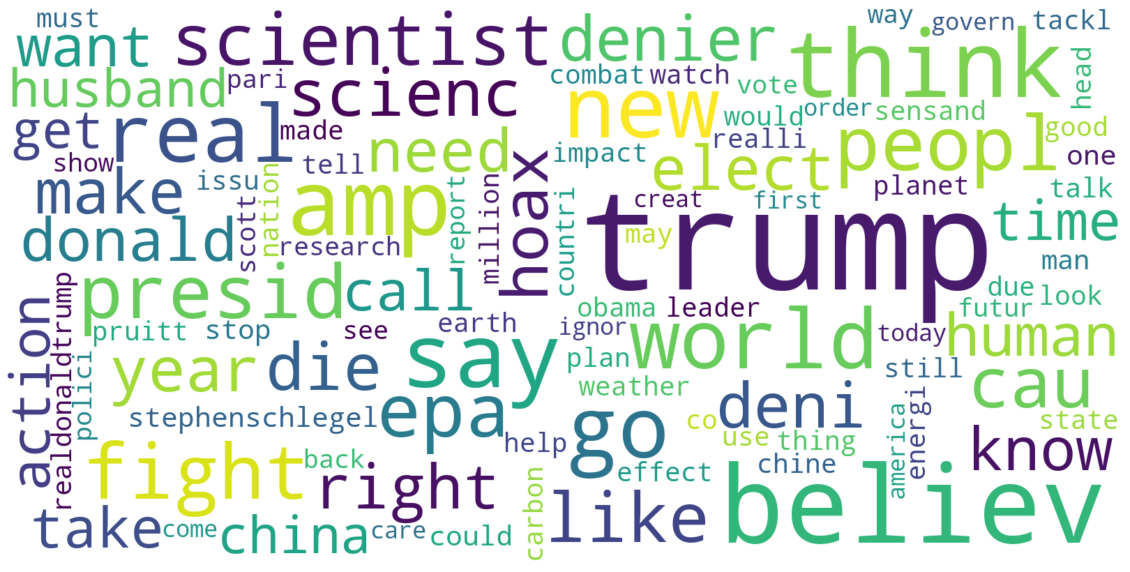

In [34]:
wordcloud_1 = WordCloud(width=1600,height=800,max_font_size=200,max_words=100,stopwords=add_stopwords,
                       collocations = False, background_color = 'white').generate(string_1)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see above, the are more sensible words in the wordcloud.

### Applying Stemming
We wil be using Porter Stemmer to stem the data.
Now, for more data processing, we use the following lines of code.

### Applying Lemmatization

A very similar operation to stemming is called lemmatization. Lemmatizing is the process of grouping words of similar meaning together. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma.


# Scaled data


In [25]:
X_scale = data['message']
y_scale = data['sentiment']

In [26]:
cleaned_data_2=[]

for i in range(len(X_scale)):
    tweet=re.sub(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?',' ',X_scale.iloc[i])  #Removing urls from messages
    tweet=re.sub('[^a-zA-Z]',' ',tweet)                                            #Makes sure only letter are in the message 
    tweet=tweet.lower().split()
    tweet=[stemmer1.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    tweet=' '.join(tweet)
    cleaned_data_2.append(tweet)

In [27]:
cleaned_data_2[:5]

['natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang',
 'sensand presid elect believ climat chang million peopl go say mr',
 'octorg fed court rule right octorg youth threaten climat chang help proceed trial',
 'aiannucci u elect trump rest world u polici climat chang threaten',
 'sensand presid elect believ climat chang frighten countri world']

### Wordcloud for feature set 2
Another wordcloud will be created to ensure the most frequent words are of importance, these additional stopwords will be appended to the list add_stopwords

In [28]:
string_2 = pd.Series(cleaned_data_2).str.cat(sep=' ') 

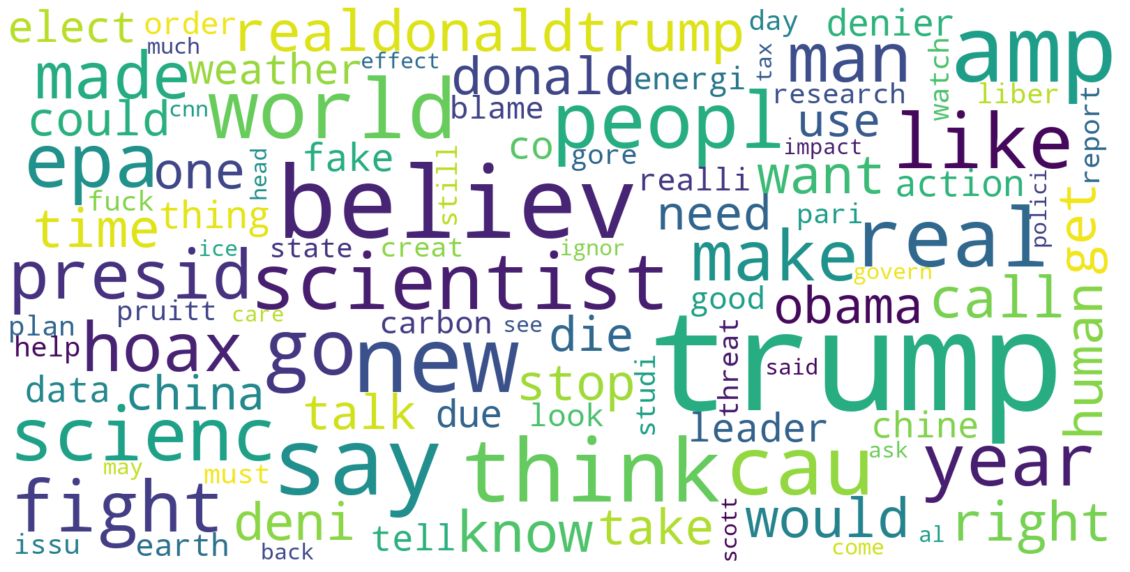

In [29]:

wordcloud_2 = WordCloud(width=1600,height=800,max_font_size=200,max_words=100,stopwords=add_stopwords,
                       collocations = False, background_color = 'white').generate(string_2)

plt.figure(figsize=(20,20))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.show()


Above we created three goups of cleaned data, with additional stopword = add_stopword, This will be used in the section below when we create our bag of words.

Let’s have a look at the output column ‘y’

In [51]:
y.head()

0    1
1    1
3    1
4    1
5    1
Name: sentiment, dtype: int64

As we can see the output is already in numeric format, so no processing is necessary.

## Build the NLP models

In this section multiple models will be build in oder to find the mosr accurate model, the accuracy of the model will be measured by the f1 score. Now to build the model we split the dataset into a training and testing section(testing size=30% of the actual data and use random_state = 42). To actually fit the model, we call the model.fit function and supply it the training input and output.

#### Splitting the Data
Three train test split goups will be created for X_fin_1 to X_fin_3 to evalute the acuracy.

In [37]:
X_1 = cleaned_data_1
y_1 = tweets['sentiment']

X_2 = cleaned_data_2
y_2 = data['sentiment']


# Split 1 (plain data with no stemming or lemmatization)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2 , random_state = 42)

# Split2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2 ,y_2, test_size=0.2 , random_state = 42)

# Scaler makes almost no difference in f1_score
#scaler = StandardScaler()
#
#X_train_1 = scaler.fit_transform(X_train_1)
#X_test_1 = scaler.transform(X_test_1)
#
#X_train_2 = scaler.fit_transform(X_train_2)
#X_test_2 = scaler.transform(X_test_2)
#
#X_train_3 = scaler.fit_transform(X_train_3)
#X_test_3 = scaler.transform(X_test_3)

## Transforming Dataset: Text to Numeric

Algoritms use numeric data to train models. Thus to make algorithms works with text, we have to convert text to numbers. We will use the Bag of Words methods to do this.

### Bag of Words
Now that input dat is clean and ready, we convert it into numbers using something called as the ‘Bag of Words’ approach. Basically we create a matrix table, where each row represents a sentence and each word will have separate column for itself that represents it’s frequency.

One con about this method that you might not notice is that the order of the sentence is lost. There are other approaches to counter this, but we are just going to stick with this method.



#### Fit CountVectorizer
Here the three feature sets of cleaned data will be fitted to CountVectorizer and then transfromed in order to produce numeric data.

In [38]:
new_stop_words = stop_words.extend(add_stopwords)

In [40]:

count_vector_1 = CountVectorizer(max_features = 5000, stop_words= new_stop_words) #stop_words
X_train_1 = count_vector_1.fit_transform(X_train_1).toarray()
X_test_1 = count_vector_1.transform(X_test_1).toarray()


count_vector_2 = CountVectorizer(max_features = 5000, stop_words= new_stop_words)
X_train_2 = count_vector_2.fit_transform(X_train_2).toarray()
X_test_2 = count_vector_2.transform(X_test_2).toarray()
                                 
#vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=5000,stop_words= new_stop_words) #
#
#X_train_1 = vectoriser.fit_transform(X_train_1).toarray()
#X_train_2 = vectoriser.fit_transform(X_train_2).toarray()
#X_test_1 = vectoriser.transform(X_test_1).toarray()
#X_test_2 = vectoriser.transform(X_test_2).toarray()

The Count Vectorizer function converts a list of words into bag of words, however notice that we specify something called as the max features to it. Basically as you might have seen in the bag of words illustration table, each word will have separate column. This number of columns can explode into large numbers in big datasets.

To avoid this we set the max columns as 2500, and basically keep the maximum occurring 2500 words. Also we set the stop_words parameter to the add_stopwords list that was created, as we want to remove that from the tweets as well.

Finall the cv.fit_transform function takes the cleaned_data and converts it into the bag of words that we wanted.

#### Model 1: MultinomialNB
I am going to use the Multinomial Naive Bayes model to figure out the relationship between the input and the output. Multinomial NB is a supervised learning algorithm that works really well for text based data.

In [41]:
# Initialize model

MNB_model_1 = MultinomialNB()

MNB_model_1.fit(X_train_1, y_train_1)
y_pred_1 = MNB_model_1.predict(X_test_1)

#c_report = classification_report(y_test, y_pred)

f1score_1 = f1_score(y_test_1, y_pred_1, average= 'macro')
print('macro f1 score:', f1score_1)

macro f1 score: 0.6157107609826313


In [42]:
MNB_model_2 = MultinomialNB()

MNB_model_2.fit(X_train_2, y_train_2)
y_pred_2 = MNB_model_2.predict(X_test_2)

#c_report = classification_report(y_test, y_pred)

f1score_2 = f1_score(y_test_2, y_pred_2, average= 'macro')
print('macro f1 score:', f1score_2)

macro f1 score: 0.734594004841638


#### Model 2: LogisticRegression

In [43]:
# Initialize model

LR_model_1 = LogisticRegression()

LR_model_1.fit(X_train_1, y_train_1)
y_pred_4 = LR_model_1.predict(X_test_1)

#c_report = classification_report(y_test, y_pred)

f1score_4 = f1_score(y_test_1, y_pred_4, average= 'macro')
print('macro f1 score:', f1score_4)

macro f1 score: 0.6397434929515279


In [44]:
LR_model_2 = LogisticRegression()

LR_model_2.fit(X_train_2, y_train_2)
y_pred_5 = LR_model_2.predict(X_test_2)

#c_report = classification_report(y_test, y_pred)

f1score_5 = f1_score(y_test_2, y_pred_5, average= 'macro')
print('macro f1 score:', f1score_5)

macro f1 score: 0.7979366123890977


#### Model 3: RandomForestClassifier

In [45]:
# Initialize model

Forest_model_1 = RandomForestClassifier()

Forest_model_1.fit(X_train_1, y_train_1)
y_pred_7 = Forest_model_1.predict(X_test_1)

#c_report = classification_report(y_test, y_pred)

f1score_7 = f1_score(y_test_1, y_pred_7, average= 'macro')
print('macro f1 score:', f1score_7)

macro f1 score: 0.5956416488304319


In [46]:
Forest_model_2 = RandomForestClassifier()

Forest_model_2.fit(X_train_2, y_train_2)
y_pred_8 = Forest_model_2.predict(X_test_2)

#c_report = classification_report(y_test, y_pred)

f1score_8 = f1_score(y_test_2, y_pred_8, average= 'macro')
print('macro f1 score:', f1score_8)

macro f1 score: 0.8129502425800489


#### Model_4: LinearSVC

In [47]:
svc_model_1 = LinearSVC()

svc_model_1.fit(X_train_1, y_train_1)
y_pred_10 = svc_model_1.predict(X_test_1)

f1score_10 = f1_score(y_test_1, y_pred_10, average= 'macro')
print('macro f1 score:', f1score_10)

macro f1 score: 0.6203957831319686


In [48]:
svc_model_2 = LinearSVC()

svc_model_2.fit(X_train_2, y_train_2)
y_pred_11 = svc_model_2.predict(X_test_2)

f1score_11 = f1_score(y_test_2, y_pred_11, average= 'macro')
print('macro f1 score:', f1score_11)

macro f1 score: 0.8029325493667716


In [62]:
# create a pickel model.

model_save_path = 'LR_model_1.pkl'

with open(model_save_path, 'wb') as file:
    pickle.dump(LR_model_1, file)

## Compare models

Models will be compared based on the f1 score the model in tabular format.
Expand on f1 score

In [49]:
model_comp = {'model_name' : ['MultinomialNB_1', 'MultinomialNB_2',
                              'LogisticRegression_1', 'LogisticRegression_2',
                              'RandomForestClassifier_1', 'RandomForestClassifier_2',
                             'LinearSVC_1', 'LinearSVC_2'
                             ],
                   'f1_score' : [f1score_1, f1score_2,
                                 f1score_4 ,f1score_5,
                                 f1score_7, f1score_8,
                                f1score_10, f1score_11]
                                 }


model_comp_df = pd.DataFrame(model_comp)

In [50]:
model_comp_df.sort_values('f1_score',ascending=False)

,model_name,f1_score
5,RandomForestClassifier_2,0.812950
7,LinearSVC_2,0.802933
3,LogisticRegression_2,0.797937
1,MultinomialNB_2,0.734594
2,LogisticRegression_1,0.639743
6,LinearSVC_1,0.620396
0,MultinomialNB_1,0.615711
4,RandomForestClassifier_1,0.595642


From the evaluation table above we can see that RandomForestClassifier_2 has the best f1 score, but on the Kaggle scoreboard it recieves a score of 0.6289. The best scoring model on the Kggale scoreboard is LogisticRegression_1 with a score of 0.71728.

Explain why it is a good choice.

## Kaggle submition


In [35]:
test_df = pd.read_csv('test_with_no_labels.csv')

In [36]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


### Preprocessing for LogisticRegression_1

In [59]:
test_df = pd.read_csv('test_with_no_labels.csv')

X_test = test_df['message']

cleaned_data=[]

for i in range(len(X_test)):
    tweet=re.sub(r'(https?://)?(www\.)?(\w+\.)?(\w+)(\.\w+)(/.+)?',' ',X_test.iloc[i])  #Removing urls from messages
    tweet=re.sub('[^a-zA-Z]',' ',tweet)                                            #Makes sure only letter are in the message 
    tweet=tweet.lower().split()
    tweet=[stemmer1.stem(word) for word in tweet if (word not in stop_words) and (word not in punct)]
    tweet = [lemmatizer.lemmatize(word) for word in tweet]
    tweet=' '.join(tweet)
    cleaned_data.append(tweet)

    
# Transform data to correct vectorizer
#X_fin = count_vector_1.transform(cleaned_data).toarray()       # Non scaled data                  
X_fin = count_vector_2.transform(cleaned_data).toarray()       # Scaled data
    

# MNB_model_1
#LR_model_1
# Forest_model_1
#svc_model_1

# MNB_model_2
#LR_model_2
# Forest_model_2
#svc_model_2
y_pred_test = svc_model_2.predict(X_fin)

test_df['sentiment'] = y_pred_test
output_df = test_df[['tweetid', 'sentiment']]

# .to_csv creates a new csv file in the local folder
output_df.to_csv('svc_model_2.csv', index = False)

In [88]:
y_pred_test

array([ 1, -1,  0, ...,  2,  2,  2], dtype=int64)